https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm

# Setup

In [ ]:
# @title Include Packages

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.multiarray import ndarray

In [ ]:
# @title Functions that do not need to be in a class

def download_file(n, p, number, scheme_or_diagram):
  from google.colab import files
  if scheme_or_diagram == 'scheme':
    files.download(f"{n}_{p}_e{number:.3f}_alpha.pkl")
    files.download(f"{n}_{p}_e{number:.3f}_beta.pkl")
    files.download(f"{n}_{p}_e{number:.3f}_gamma.pkl")
  if scheme_or_diagram == 'diagram':
    files.download(f'{n}_scheme_{p}_prod_{number:.3f}_best.png')

def delete_file(n, p, number, scheme_or_diagram):
  import os
  if scheme_or_diagram == 'scheme':
    os.remove(f"{n}_{p}_e{number:.3f}_alpha.pkl")
    os.remove(f"{n}_{p}_e{number:.3f}_beta.pkl")
    os.remove(f"{n}_{p}_e{number:.3f}_gamma.pkl")
  if scheme_or_diagram == 'diagram':
    os.remove(f'{n}_scheme_{p}_prod_{number:.3f}_best.png')

def heat_plot(M, title="title=", xlabel="xlabel=", ylabel="ylabel="):
  plt.imshow(M, cmap='seismic', interpolation='nearest')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

def graph_avgs(data, run_size, color='blue', alpha=1.0):
  window = round(len(data)/run_size)
  half = round(window/2)
  average_y = []
  for ind in range(half - 1):
    average_y.append(np.nan)
  for ind in range(len(data) - window + 1):
    average_y.append(np.mean(data[ind:ind+window]))
  for ind in range(window - half):
    average_y.append(np.nan)
  plt.plot([i for i in range(len(data))], average_y, color=color, alpha=alpha)

def permutation_matrix(indices):
  n = len(indices)
  matrix = np.zeros((n, n), dtype=int)
  for i, idx in enumerate(indices):
      matrix[i, idx] = 1
  return matrix

def random_unitary(n):
  from scipy.linalg import qr
  H = np.random.randn(n, n)
  Q, R = qr(H)
  return Q

def find_row_clustering(_matrix, verbose=0):
  matrix = _matrix.copy()
  size = matrix.shape[0]
  clusters = list([[i] for i in range(size)])
  similarity = np.matmul(np.abs(matrix), np.abs(matrix).T)
  plt.show()

  while len(clusters) != 1:
    max_between = 0.0
    coordinate = (0,1)
    for row in range(size):
      for col in range(row+1,size):
        if similarity[row,col] > max_between:
          max_between = similarity[row,col]
          coordinate = (row,col)

    matrix[coordinate[0],:] = (matrix[coordinate[0],:] + matrix[coordinate[1],:])/2.0
    matrix[:,coordinate[0]] = (matrix[:,coordinate[0]] + matrix[:,coordinate[1]])/2.0
    matrix = np.concatenate((matrix[:coordinate[1],:], matrix[coordinate[1]+1:,:]), axis=0)
    matrix = np.concatenate((matrix[:,:coordinate[1]], matrix[:,coordinate[1]+1:]), axis=1)

    similarity = np.matmul(np.abs(matrix), np.abs(matrix).T)

    clusters[coordinate[0]].extend(clusters[coordinate[1]])
    clusters = clusters[:coordinate[0]] + clusters[coordinate[0]:coordinate[1]] + clusters[coordinate[1]+1:]

    size -= 1

  if verbose > 0 :
    perm = permutation_matrix(clusters[0])
    heat_plot(np.abs(perm @ _matrix) @ np.abs(perm @ _matrix).T, "Product Clusters", "", "")
    plt.show()

  return clusters[0]

def default_identity(GA, GB, AB, n):
  if GA is None:
    GA = np.identity(n)
  if GB is None:
    GB = np.identity(n)
  if AB is None:
    AB = np.identity(n)
  return GA, GB, AB

def enforce_vector_triple_dot_ones(a, b, c, n, sig_figs=15, split_mode='inv_sqrt'):
  if a is None:
      a = np.ones((n,))
  if b is None:
      b = np.ones((n,))
  if c is None:
      c = np.ones((n,))
  c = c/(a*b*c)
  return a,b,c

def left_axis_size(GA, GB, AB, _n=None):
  n = None
  if GA is not None:
    n = GA.shape[0]
  if GB is not None:
    if n is None:
      n = GB.shape[0]
    elif GB.shape[0] != n:
      print("The basis matrices must have the same left dimensions")
      return
  if AB is not None:
    if n is None:
      n = AB.shape[0]
    elif AB.shape[0] != n:
      print("The basis matrices must have the same left dimensions")
      return
  if n is None:
    n=_n
  if n is None:
    n=2
  return n

def random_right_invertible(n, s=None, m=None):
  if m is None or m < n:
    m = n
  if s is None:
    s = np.ones((n,))
  _S_ = np.pad(np.diag(s), ((0, 0), (0,m-n)), 'constant', constant_values=((0, 0), (0,0)))
  return random_unitary(n) @ _S_ @ random_unitary(m)

def max_array(array, axis=None):
  if np.shape(array) == ():
    return array
  elif axis is None:
    return np.full(shape=np.shape(array), fill_value=np.max(array))
  else:
    out = np.repeat(np.amax(array, axis=axis), repeats=array.shape[1])
    print(out)
    out = np.repeat(out, repeats=array.shape[1])
    print(out)
    return out

In [ ]:
# @title A Factory for setting preset schema
class SchemaFactory(object):

  def __init__(self):
    return

  def set_TRIPLE_DELTA(self, scheme):
    scheme.TRIPLE_DELTA_nnnnnn = np.einsum("ac,BC,Ab->cCaAbB", np.identity(scheme.n), np.identity(scheme.n), np.identity(scheme.n))
    scheme.TRIPLE_DELTA_n2n4 = scheme.TRIPLE_DELTA_nnnnnn.reshape((scheme.n**2, scheme.n**4))


  def set_scheme(self, scheme, preset='random', n=None, p=None, fourier_level=2):
    if n is not None:
      scheme.n = n
    if scheme.n is None:
      scheme.n = 2
    if p is not None:
      scheme.p = p
    if scheme.p is None:
      scheme.p = scheme.n**3

    match preset:
      case 'random':
        self.set_random(scheme)
      case 'complex':
        self.set_random_complex(scheme)
      case 'naive':
        self.set_naive(scheme)
      case 'fourier':
        self.set_Fourier(scheme, level=fourier_level)
      case 'strassen':
        self.set_Strassen(scheme)
      case 'winograd':
        self.set_Winograd(scheme)
      case 'laderman':
        self.set_Laderman(scheme)

    self.set_TRIPLE_DELTA(scheme)


  def set_random(self, scheme, std_dev=1, norm=2):
    scheme.alpha_pnn = np.random.normal(scale = std_dev, size=(scheme.p, scheme.n, scheme.n))
    scheme.beta_pnn  = np.random.normal(scale = std_dev, size=(scheme.p, scheme.n, scheme.n))
    scheme.gamma_nnp = np.random.normal(scale = std_dev, size=(scheme.n, scheme.n, scheme.p))
    SchemeManipulator().set_norm(scheme, norm=norm, field="R")

  def set_random_complex(self, scheme, Re_std_dev=1, Im_std_dev=1, norm=1):
    scheme.alpha_pnn = np.random.normal(scale = Re_std_dev, size=(scheme.p, scheme.n, scheme.n)) + np.random.normal(scale = Im_std_dev, size=(scheme.p, scheme.n, scheme.n))*1j
    scheme.beta_pnn  = np.random.normal(scale = Re_std_dev, size=(scheme.p, scheme.n, scheme.n)) + np.random.normal(scale = Im_std_dev, size=(scheme.p, scheme.n, scheme.n))*1j
    scheme.gamma_nnp = np.random.normal(scale = Re_std_dev, size=(scheme.n, scheme.n, scheme.p)) + np.random.normal(scale = Im_std_dev, size=(scheme.n, scheme.n, scheme.p))*1j
    SchemeManipulator().set_norm(scheme, norm=norm, field="C")

  def set_from_basis(self, scheme, GA=None, GB=None, AB=None,
                     a_a=None, a_b=None, a_c=None, b_a=None, b_b=None, b_c=None, c_a=None, c_b=None, c_c=None,
                     norm=1, sig_figs=15): # works best with well-conditioned matrices and vectors close to ones().

    scheme.n = left_axis_size(GA, GB, AB, scheme.n)

    GA, GB, AB = default_identity(GA, GB, AB, scheme.n)

    a_a, b_a, c_a = enforce_vector_triple_dot_ones(a_a, b_a, c_a, GB.shape[1], sig_figs=sig_figs)
    a_b, b_b, c_b = enforce_vector_triple_dot_ones(a_b, b_b, c_b, GA.shape[1], sig_figs=sig_figs)
    a_c, b_c, c_c = enforce_vector_triple_dot_ones(a_c, b_c, c_c, AB.shape[1], sig_figs=sig_figs)

    field = 'R'
    if GA.dtype == complex or GB.dtype == complex or AB.dtype == complex:
      field = 'C'

    scheme.p = GA.shape[1]*GB.shape[1]*AB.shape[1] # does not support low-rank schemes. Pseudoinverses would allow shcemes with more multiplications (not helpful)

    GA_inv = np.linalg.pinv(GA)
    GB_inv = np.linalg.pinv(GB)
    AB_inv = np.linalg.pinv(AB)

    scheme.alpha_pnn = np.einsum("ia,i,   j,Ak,k->ijkaA", GA_inv, a_b,         a_a, AB,     a_c).reshape((scheme.p,scheme.n,scheme.n)).astype(complex)
    scheme.beta_pnn  = np.einsum(   "i,jB,j,kb,k->ijkbB",         b_b, GB_inv, b_a, AB_inv, b_c).reshape((scheme.p,scheme.n,scheme.n)).astype(complex)
    scheme.gamma_nnp = np.einsum("ci,i,Cj,j,   k->cCijk", GA,     c_b, GB,     c_a,         c_c).reshape((scheme.n,scheme.n,scheme.p)).astype(complex)

    self.set_TRIPLE_DELTA(scheme)
    SchemeManipulator().set_norm(scheme, norm=norm, field=field)

  def set_naive(self, scheme, norm=1, field='R'):
    self.set_from_basis(scheme)
    scheme.field = field

  def set_Fourier(self, scheme, level=2, norm=1):
    if level <= 0:
      self.set_from_basis(scheme, norm=norm)
      return

    w = np.exp(2 * 3.141592653589793238462643383279502884197j / scheme.n) # may need to make a different method to get a more accurate root of unity
    vandermond = np.fromfunction(lambda k,A : w**(k*A), (scheme.n,scheme.n))
    if level == 1:
      self.set_from_basis(scheme, AB=vandermond, norm=norm)
      return
    elif level == 2:
      self.set_from_basis(scheme, GA=vandermond, GB=vandermond, AB=vandermond, norm=norm)
      return

    fourier_vector = np.fromfunction(lambda k : w**(k), (scheme.n,))
    if level == 3:
      self.set_from_basis(scheme, GA=vandermond, GB=vandermond, AB=vandermond,
                           a_a=fourier_vector,
                           b_b=fourier_vector,
                           c_c=fourier_vector, norm=norm)
      return
    elif level >= 4:
      self.set_from_basis(scheme, GA=vandermond, GB=vandermond, AB=vandermond,
                           a_a=fourier_vector,
                           a_b=fourier_vector,
                           b_a=fourier_vector,
                           b_b=fourier_vector,
                           c_a=fourier_vector,
                           c_b=fourier_vector, norm=norm)
      return

  def set_Strassen(self, scheme):
    scheme.n = 2
    scheme.p = 7
    scheme.alpha_pnn = np.array([[[ 1,0],[0, 1]],[[ 0,0],[1, 1]],[[ 1,0],[0, 0]],[[ 0,0],[0, 1]],[[ 1,1],[0, 0]],[[-1,0],[1, 0]],[[ 0,1],[0,-1]]]).astype(float)
    scheme.beta_pnn  = np.array([[[ 1,0],[0, 1]],[[ 1,0],[0, 0]],[[ 0,1],[0,-1]],[[-1,0],[1, 0]],[[ 0,0],[0, 1]],[[ 1,1],[0, 0]],[[ 0,0],[1, 1]]]).astype(float)
    scheme.gamma_nnp = np.array([[[1, 0,0,1,-1,0,1], [0, 0,1,0, 1,0,0]],[[0, 1,0,1, 0,0,0], [1,-1,1,0, 0,1,0]]]).astype(float)
    SchemeManipulator().set_norm(scheme, norm=1)
    SchemeManipulator().permute_products(scheme)

  def set_Winograd(self, scheme):
    scheme.n = 2
    scheme.p = 7
    scheme.alpha_pnn = np.array([[[ 1,0],[ 0, 0]],[[ 0,1],[ 0, 0]],[[ 1,1],[-1,-1]],[[ 0,0],[ 0, 1]],[[-1,0],[ 1, 0]],[[ 0,0],[ 1, 1]],[[-1,0],[ 1, 1]]]).astype(float)
    scheme.beta_pnn  = np.array([[[ 1, 0],[0, 0]],[[ 0, 0],[1, 0]],[[ 0, 0],[0, 1]],[[-1, 1],[1,-1]],[[ 0, 1],[0,-1]],[[-1, 1],[0, 0]],[[ 1,-1],[0, 1]]]).astype(float)
    scheme.gamma_nnp = np.array([[[1,1,0,0,0,0,0], [1,0,1,0,0,1,1]],[[1,0,0,1,1,0,1], [1,0,0,0,1,1,1]]]).astype(float)
    SchemeManipulator().set_norm(scheme, norm=1)
    SchemeManipulator().permute_products(scheme)

  # def set_Perry(self, scheme):
  #   scheme.n = 2
  #   scheme.p = 7
  #   scheme.alpha_pnn = np.array([[[ 1,0],[0, 1j]],[[1, 0],[-1, 0]],[[ 0,1j],[ 0,-1j]],[[1,0],[0, 0]],[[0,0],[0, 1j]],[[0,0],[1,1j]],[[1,1j],[0,0]]]).astype(complex)
  #   scheme.beta_pnn  = np.array([[[ 1,0],[0, 1j]],[[1,-1],[ 0, 0]],[[ 0,0 ],[1j, 1j]],[[0,1],[0,1j]],[[1,0],[-1j,0]],[[1,0],[0, 0]],[[0,0],[0, 1j]]]).astype(complex)
  #   scheme.gamma_nnp = np.array([[[1, 0,1,0,-1,0,-1], [0, 0,0,1, 0,0,-1]],[[0, 0,0,0, 1,1,0], [-1,1,0,1, 0,1,0]]]).astype(complex)
  #   SchemeManipulator().set_norm(scheme, norm=1)
  #   SchemeManipulator().permute_products(scheme)

  def set_Laderman(self, scheme):
    scheme.n = 3
    scheme.p = 23
    scheme.alpha_pnn = np.array([[[ 1,1, 1],[-1,-1, 0],[ 0,-1,-1]],[[ 1,0, 0],[-1, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 1, 0],[ 0, 0, 0]],[[-1,0, 0],[ 1, 1, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 1, 1, 0],[ 0, 0, 0]], # 5
                               [[ 1,0, 0],[ 0, 0, 0],[ 0, 0, 0]],[[-1,0, 0],[ 0, 0, 0],[ 1, 1, 0]],[[-1,0, 0],[ 0, 0, 0],[ 1, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 1, 1, 0]],[[ 1,1, 1],[ 0,-1,-1],[-1,-1, 0]], # 10
                               [[ 0,0, 0],[ 0, 0, 0],[ 0, 1, 0]],[[ 0,0,-1],[ 0, 0, 0],[ 0, 1, 1]],[[ 0,0, 1],[ 0, 0, 0],[ 0, 0,-1]],[[ 0,0, 1],[ 0, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 0, 1, 1]], # 15
                               [[ 0,0,-1],[ 0, 1, 1],[ 0, 0, 0]],[[ 0,0, 1],[ 0, 0,-1],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 1, 1],[ 0, 0, 0]],[[ 0,1, 0],[ 0, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 1],[ 0, 0, 0]], # 20
                               [[ 0,0, 0],[ 1, 0, 0],[ 0, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 1, 0, 0]],[[ 0,0, 0],[ 0, 0, 0],[ 0, 0, 1]]]).astype(float)
    scheme.beta_pnn  = np.array([[[ 0, 0, 0],[0, 1, 0],[ 0, 0, 0]],[[ 0,-1, 0],[0, 1, 0],[ 0, 0, 0]],[[-1, 1, 0],[1,-1,-1],[-1, 0, 1]],[[ 1,-1, 0],[0, 1, 0],[ 0, 0, 0]],[[-1, 1, 0],[0, 0, 0],[ 0, 0, 0]], # 5
                               [[ 1, 0, 0],[0, 0, 0],[ 0, 0, 0]],[[ 1, 0,-1],[0, 0, 1],[ 0, 0, 0]],[[ 0, 0, 1],[0, 0,-1],[ 0, 0, 0]],[[-1, 0, 1],[0, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 1],[ 0, 0, 0]], # 10
                               [[-1, 0, 1],[1,-1,-1],[-1, 1, 0]],[[ 0, 0, 0],[0, 1, 0],[ 1,-1, 0]],[[ 0, 0, 0],[0, 1, 0],[ 0,-1, 0]],[[ 0, 0, 0],[0, 0, 0],[ 1, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[-1, 1, 0]], # 15
                               [[ 0, 0, 0],[0, 0, 1],[ 1, 0,-1]],[[ 0, 0, 0],[0, 0, 1],[ 0, 0,-1]],[[ 0, 0, 0],[0, 0, 0],[-1, 0, 1]],[[ 0, 0, 0],[1, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[ 0, 1, 0]], # 20
                               [[ 0, 0, 1],[0, 0, 0],[ 0, 0, 0]],[[ 0, 1, 0],[0, 0, 0],[ 0, 0, 0]],[[ 0, 0, 0],[0, 0, 0],[ 0, 0, 1]]]).astype(float)
    scheme.gamma_nnp = np.array([[[0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0], [1,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0]],
                               [[0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0], [0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0]],
                               [[0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0], [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]]).astype(float)
    SchemeManipulator().set_norm(scheme, norm=1) #10        15        20                  5        10        15        20                  5        10        15        20
    SchemeManipulator().permute_products(scheme)

  def set_from(self, scheme, alpha_pnn, beta_pnn, gamma_nnp, norm=1):
    scheme.n = alpha_pnn.shape[1]
    scheme.p = alpha_pnn.shape[0]

    field = 'R'
    if alpha_pnn.dtype == complex:
      field = 'C'
    SchemeManipulator().set_norm(scheme, norm=norm, field=field)

    scheme.alpha_pnn = alpha_pnn
    scheme.beta_pnn = beta_pnn
    scheme.gamma_nnp = gamma_nnp

    self.set_TRIPLE_DELTA(scheme)

  def read_from_files(self, scheme, n=None, p=None, number=None, filename=None, verbose=0):
    if filename is None:
      if n is None and p is None and number is not None:
        filename = f'{float(number):.3f}'
      elif n is not None and p is not None and number is not None:
        filename = f'{n}_{p}_e{float(number):.3f}'
      else:
        print('must provide a file header, number, or scheme sizes')
    import pickle
    file1 = open(f'{filename}_alpha.pkl', 'rb')
    alpha_pnn = pickle.load(file1)
    file1.close()
    file1 = open(f'{filename}_beta.pkl', 'rb')
    beta_pnn = pickle.load(file1)
    file1.close()
    file1 = open(f'{filename}_gamma.pkl', 'rb')
    gamma_nnp = pickle.load(file1)
    file1.close()

    self.set_from(scheme, alpha_pnn, beta_pnn, gamma_nnp)
    if verbose > 0: SchemeDisplay().print(scheme, verbose=verbose)

  def compose_schemes(self, outer, inner): # cCaAbBi, zZxXyY
    result = BrentScheme()
    result.n = outer.n * inner.n
    result.p = outer.p * inner.p
    SchemaFactory().set_TRIPLE_DELTA(result)
    result.gamma_nnp = np.einsum('cCi,zZj->czCZij', outer.gamma_nnp, inner.gamma_nnp).reshape((result.n, result.n, result.p))
    result.alpha_pnn = np.einsum('iaA,jxX->ijaxAX', outer.alpha_pnn, inner.alpha_pnn).reshape((result.p, result.n, result.n))
    result.beta_pnn  = np.einsum('ibB,jyY->ijbyBY', outer.beta_pnn,  inner.beta_pnn).reshape( (result.p, result.n, result.n))
    SchemeManipulator().permute_products(result)
    return result

factory = SchemaFactory()

In [ ]:
# @title A Manipulation object for an existing scheme FIXME: Linf norm (convert all to pytorch), change_basis (check pseudoinverses)
class SchemeManipulator(object):

  def __init__(self):
    return

  def set_norm(self, scheme, norm=1, field=None):
    scheme.L_norm = norm

    if field is None:
      scheme.field = 'R'
      if scheme.alpha_pnn.dtype == complex:
        scheme.field = 'C'
    else:
      scheme.field = field

    if scheme.field == 'R':
      scheme.alpha_pnn = np.real(scheme.alpha_pnn)
      scheme.beta_pnn = np.real(scheme.beta_pnn)
      scheme.gamma_nnp = np.real(scheme.gamma_nnp)
    elif scheme.field == 'C':
      scheme.alpha_pnn = scheme.alpha_pnn.astype(complex)
      scheme.beta_pnn = scheme.beta_pnn.astype(complex)
      scheme.gamma_nnp = scheme.gamma_nnp.astype(complex)

    scheme._filter = None
    if scheme.field == 'R':
      scheme._filter = lambda x : x
    elif scheme.field == 'C':
      scheme._filter = lambda x : scheme.norm(x)

    if norm < 1:
      print(f"THE L{norm} NORM IS NOT SUPPORTED: TRY [1,inf]")
      return
    if norm == np.inf:
      scheme.norm = lambda x : max_array(np.abs(x), axis=np.where(np.shape(x)==scheme.p)[0]) # possibly broken - requires a scheme with size p to actually measure
      scheme.inv_norm = lambda x,size : x/size
      scheme.d_norm = lambda x : np.heaviside(np.abs(x) - scheme.norm(x), np.ones(np.shape(x)))
      return
    if norm == 1: # specialize for speedup
      scheme.norm = lambda x : np.abs(x)
      scheme.inv_norm = lambda x,size=None : x # a norm should be F -> R, so this is ok
      scheme.d_norm = lambda x : x / np.where(np.abs(x)<=0.0, 1, np.abs(x)) # valid over R and I
      return
    if scheme.field == 'R' and norm == 2:
      scheme.norm = lambda x : np.power(np.abs(x), 2)
      scheme.inv_norm = lambda x,size=None : np.power(x, 1.0/2) # a norm should be F -> R, so this is ok
      scheme.d_norm = lambda x : 2*x # valid over R not I
      return
    scheme.norm = lambda x : np.power(np.abs(x), norm)
    scheme.inv_norm = lambda x,size=None : np.power(x, 1.0/norm) # a norm should be F -> R, so this is ok
    scheme.d_norm = lambda x : norm * np.power(np.abs(x), norm-1) * x / np.where(np.abs(x)<=0.0, 1, np.abs(x)) # valid over R and I

  def scale_products(self, scheme, a, b):
    a = np.array(a)
    b = np.array(b)
    scheme.alpha_pnn = np.einsum("iaA,i->iaA", scheme.alpha_pnn, a)
    scheme.beta_pnn  = np.einsum("ibB,i->ibB", scheme.beta_pnn, b)
    scheme.gamma_nnp = np.einsum("cCi,i,i->cCi", scheme.gamma_nnp, 1/a, 1/b)

  def normalize(self, scheme, verbose=0):
    if verbose > 0: SchemeDisplay().print(scheme)

    # print(scheme.norm(scheme.alpha_pnn))
    # print(np.einsum("iaA->i", scheme.norm(scheme.alpha_pnn)))

    alpha_mags_p = scheme.inv_norm(np.einsum("iaA->i", scheme.norm(scheme.alpha_pnn)), scheme.n**2)
    beta_mags_p  = scheme.inv_norm(np.einsum("ibB->i", scheme.norm(scheme.beta_pnn)), scheme.n**2)

    if verbose > 0: print("alpha magnitudes: ", alpha_mags_p, " beta magnitudes: ", beta_mags_p)

    alpha_mags_p[alpha_mags_p == 0.0] = 1.0
    beta_mags_p[beta_mags_p   == 0.0] = 1.0

    self.scale_products(scheme, 1/alpha_mags_p, 1/beta_mags_p)
    self.permute_products(scheme, verbose=verbose-2)

    if verbose > 0:
      print("")
      SchemeDisplay().print(scheme)

  def permute_products(self, scheme, permutation=None, verbose=0):
    if permutation is None:
      gamma, products = scheme.flatten()
      u,_,__ = np.linalg.svd(products)
      permutation = find_row_clustering(u, verbose=verbose)

    permutation = permutation_matrix(permutation)
    scheme.alpha_pnn = np.einsum('ij,jaA->iaA', permutation, scheme.alpha_pnn)
    scheme.beta_pnn  = np.einsum('ij,jbB->ibB', permutation, scheme.beta_pnn)
    scheme.gamma_nnp = np.einsum('cCj,ij->cCi', scheme.gamma_nnp, permutation)

  def add_noise(self, scheme, epsilon=10**-15):
    scheme.alpha_pnn += np.random.normal(scale = epsilon, size=(scheme.p, scheme.n, scheme.n))
    scheme.beta_pnn  += np.random.normal(scale = epsilon, size=(scheme.p, scheme.n, scheme.n))
    scheme.gamma_nnp += np.random.normal(scale = epsilon, size=(scheme.n, scheme.n, scheme.p))

  def round(self, scheme, sig_figs=15): # rounds each coefficient to a certian significant place
    scheme.alpha_pnn = scheme.alpha_pnn.round(decimals=sig_figs)
    scheme.beta_pnn  = scheme.beta_pnn.round(decimals=sig_figs)
    scheme.gamma_nnp = scheme.gamma_nnp.round(decimals=sig_figs)

  def drop_product(self, scheme, prod=None, verbose=0):
    if prod is None:
      return
    prod -= 1
    scheme.alpha_pnn = np.concatenate((scheme.alpha_pnn[:prod,:,:], scheme.alpha_pnn[prod+1:,:,:]), axis=0)
    scheme.beta_pnn  = np.concatenate((scheme.beta_pnn[:prod,:,:],  scheme.beta_pnn[prod+1:,:,:]),  axis=0)
    scheme.gamma_nnp = np.concatenate((scheme.gamma_nnp[:,:,:prod], scheme.gamma_nnp[:,:,prod+1:]), axis=2)

    scheme.p = scheme.p - 1
    if verbose > 0: print(f'p is now: {scheme.p}')

  def chop(self, scheme, num=0, verbose=0): # drops the least significant product from the central sum
    for i in range(num):
      gamma_scores_p = np.einsum("ijk->k", scheme.norm(scheme.gamma_nnp))
      if verbose > 1: print(f"The gamma 2-tensors associated with each product have magnitudes: {gamma_scores_p}")
      _g = np.argmin(gamma_scores_p)
      if verbose > 1: print(f"Dropping the product with magnitude: {gamma_scores_p[_g]}")
      self.drop_product(scheme, prod=_g+1, verbose=verbose)

  def enforce_zero_num(self, scheme, num_zeros_enforced=0, sig_figs=15, decay_factor=0.7):
    manipulator = SchemeManipulator()
    manipulator.round(scheme, sig_figs)

    gamma_pnn = np.transpose(scheme.gamma_nnp, axes=(2,1,0))
    array = np.array([gamma_pnn, scheme.alpha_pnn, scheme.beta_pnn])

    while num_zeros_enforced > 0:
      min_elem_indeces = np.argsort(np.abs(array), axis=None)
      min_elem_indeces = np.unravel_index(min_elem_indeces, shape=array.shape)
      for tensor, d, D, p in zip(*min_elem_indeces):
        if num_zeros_enforced <= 0:
          break
        array[tensor, d, D, p] *= decay_factor
        num_zeros_enforced -= 1

    scheme.gamma_nnp = np.transpose(array[0], axes=(2,1,0))
    scheme.alpha_pnn = array[1]
    scheme.beta_pnn  = array[2]

  def reduce_matrices(self, scheme, axes=[[],[],[]]):
    for i in range(3):
      if axes[i] is None:
        axes[i] = []
      elif isinstance(axes[i], int):
        axes[i] = [axes[i]]
      axes[i].sort(reverse=True)

    if len(axes[0]) != len(axes[1]) or len(axes[0]) != len(axes[2]):
      print("WARNING: THE OTHER METHODS DO NOT WORK WITH RECTANGULAR MATRICES")

    scheme.n -= len(axes[0])
    SchemaFactory().set_TRIPLE_DELTA(scheme)

    for row in axes[0]:
      scheme.gamma_nnp = np.delete(scheme.gamma_nnp, row, 0)
      scheme.alpha_pnn = np.delete(scheme.alpha_pnn, row, 1)
    for prod in axes[1]:
      scheme.alpha_pnn = np.delete(scheme.alpha_pnn, prod, 2)
      scheme.beta_pnn  = np.delete(scheme.beta_pnn, prod, 1)
    for col in axes[2]:
      scheme.beta_pnn  = np.delete(scheme.beta_pnn, col, 2)
      scheme.gamma_nnp = np.delete(scheme.gamma_nnp, col, 1)

  def clean(self, scheme):
    for prod in range(scheme.p-1, -1, -1):
      # if the product has a zero side or if the product is not used in gamma
      if np.count_nonzero(scheme.alpha_pnn[prod,:,:]) == 0 or np.count_nonzero(scheme.beta_pnn[prod,:,:]) == 0 or np.count_nonzero(scheme.gamma_nnp[:,:,prod]) == 0:
        scheme.gamma_nnp = np.delete(scheme.gamma_nnp, prod, 2)
        scheme.alpha_pnn = np.delete(scheme.alpha_pnn, prod, 0)
        scheme.beta_pnn  = np.delete(scheme.beta_pnn,  prod, 0)
        scheme.p -= 1
      self.permute_products(scheme)

  def change_basis(self, scheme, GA=None, GB=None, AB=None,
                     a_a=None, a_b=None, a_c=None, b_a=None, b_b=None, b_c=None, c_a=None, c_b=None, c_c=None,
                     norm=1, sig_figs=15): # works best with well-conditioned matrices and vectors close to ones().

    # basis change is: (GA)C(GB) = (GA)A(AB)(AB_inv)B(GB)
    # where the new scheme uses C' = (GA)C(GB), A' = (GA)A(AB), and B' = (AB_inv)B(GB)

    scheme.n = left_axis_size(GA, GB, AB, scheme.n)

    GA, GB, AB = default_identity(GA, GB, AB, scheme.n)

    field = 'R'
    if GA.dtype == complex or GB.dtype == complex or AB.dtype == complex:
      field = 'C'

    GA_inv = np.linalg.pinv(GA)
    GB_inv = np.linalg.pinv(GB)
    AB_inv = np.linalg.pinv(AB)

    scheme.alpha_pnn = np.einsum("ax,XA,ixX->iaA", GA,             AB    , scheme.alpha_pnn).astype(complex)
    scheme.beta_pnn  = np.einsum("XB,bx,ixX->ibB",         GB,     AB_inv, scheme.beta_pnn ).astype(complex)
    scheme.gamma_nnp = np.einsum("xc,CX,xXi->cCi", GA_inv, GB_inv,         scheme.gamma_nnp).astype(complex)

    SchemaFactory().set_TRIPLE_DELTA(scheme)
    self.set_norm(scheme, norm=norm, field=field)

    return


manipulator = SchemeManipulator()

In [ ]:
# @title A Scheme for multiplying matrices
class BrentScheme(object):

  def __init__(self, n=None, p=None, verbose=0):
    self.n = n
    self.p = p
    factory = SchemaFactory()
    factory.set_scheme(self, preset='random')
    factory.set_TRIPLE_DELTA(self)
    if verbose > 0: print(f"The net started with {self.p} products")

  def complexity(self):
    import math
    return math.log(self.p,self.n)

  def measure(self, X):
    return self.inv_norm(np.sum(self.norm(X)), 1)

  def avg_error(self, X):
    return self.inv_norm(np.sum(self.norm(X)) / np.size(X))

  def predict(self, A_nn, B_nn): # slightly different than forward, uses flattened method
    return np.einsum("cCi,iaA,ibB,aA,bB->cC", self.gamma_nnp, self.alpha_pnn, self.beta_pnn, A_nn, B_nn)

  def forward(self, A_nn, B_nn):
    alpha_sums_p = np.einsum("iaA,aA->i", self.alpha_pnn, A_nn)
    beta_sums_p = np.einsum("ibB,bB->i", self.beta_pnn, B_nn)
    products_p = alpha_sums_p * beta_sums_p
    AB_prediction_nn = np.einsum("cCi,i->cC", self.gamma_nnp, products_p)
    return AB_prediction_nn, alpha_sums_p, beta_sums_p, products_p

  def flatten(self):
    alpha_beta_pn4 = np.einsum("iaA,ibB->iaAbB", self.alpha_pnn, self.beta_pnn).reshape(self.p, self.n**4)
    gamma_n2p = self.gamma_nnp.reshape(self.n**2, self.p)
    return gamma_n2p, alpha_beta_pn4

  def triple_delta(self):
    return np.einsum("cCi,iaA,ibB->cCaAbB", self.gamma_nnp, self.alpha_pnn, self.beta_pnn)

scheme = BrentScheme() # generate a random one just so we have the variable

In [ ]:
# @title A Display object for printing and saving data about a scheme, including accuracy tests
class SchemeDisplay(object):

  def __init__(self):
    return

  def print(self, scheme, verbose=0):
    print(f"Network trained for a {scheme.n} by {scheme.n} matrix using {scheme.p} out of {scheme.n**3} multiplications; complexity is n^{scheme.complexity():.3f}\n\nUsing the L{scheme.L_norm} norm over the field {scheme.field}\n")

    if verbose > 0:
      self.test(scheme, verbose=min(verbose, 1))
      print("")

    if verbose > 1:
      alphas = [[f'{scheme.alpha_pnn[pi,aj,ak]: .3f}*A[{aj+1},{ak+1}]' if scheme.alpha_pnn[pi,aj,ak] != 0.0 else "" for aj in range(scheme.n) for ak in range(scheme.n)] for pi in range(scheme.p)]
      alpha_sums = ["".join([f'{alphas[pi][elem]} + ' if alphas[pi][elem] != "" else "" for elem in range(scheme.n**2)])[:-3] for pi in range(scheme.p)]

      betas = [[f'{scheme.beta_pnn[pi,bj,bk]: .3f}*B[{bj+1},{bk+1}]' if scheme.beta_pnn[pi,bj,bk] != 0.0 else "" for bj in range(scheme.n) for bk in range(scheme.n)] for pi in range(scheme.p)]
      beta_sums  = ["".join([f'{betas[pi][elem]} + ' if betas[pi][elem] != "" else "" for elem in range(scheme.n**2)])[:-3] for pi in range(scheme.p)]

      products = [f'({alpha_sums[pi]}) * ({beta_sums[pi]})' for pi in range(scheme.p)]
      print("Products P_i = (alpha_iaa' *_aa' A_aa') *_i (beta_ibb' *_bb' B_bb')")
      for pi in range(scheme.p): print(f"P_{pi+1} =", products[pi])
      print("")

      gammas = [[[f'{scheme.gamma_nnp[gi,gj,gk]: .3f}*P_{gk+1}' if scheme.gamma_nnp[gi,gj,gk] != 0.0 else "" for gk in range(scheme.p)] for gj in range(scheme.n)] for gi in range(scheme.n)]
      gamma_sums = [["".join([f'{gammas[c1][c2][pi]} + ' if gammas[c1][c2][pi] != "" else "" for pi in range(scheme.p)])[:-3] for c2 in range(scheme.n)]for c1 in range(scheme.n)]
      print("Outputs AB_cc' = gamma_cc'i *_i P_i")
      for c1 in range(scheme.n):
        for c2 in range(scheme.n):
          print(f"AB[{c1+1},{c2+1}] =", gamma_sums[c1][c2])
      print("")

  def display_spectra(self, scheme, verbose=0):
    if verbose > 0: print("red are the coefficients in alpha, blue in beta, and yellow in gamma")

    plt.hist(scheme._filter(scheme.alpha_pnn.flatten()), color='red',    alpha=0.3, bins=30)
    plt.hist(scheme._filter(scheme.beta_pnn.flatten()) , color='blue',   alpha=0.3, bins=30)
    plt.hist(scheme._filter(scheme.gamma_nnp.flatten()), color='yellow', alpha=0.3, bins=30)
    plt.show()

  def eigen_heatmap(self, scheme):
    gamma, products = scheme.flatten()
    plt.figure(figsize=(12, 7))

    u,s,v_t = np.linalg.svd(gamma)

    plt.subplot(1, 4, 1)
    heat_plot(scheme._filter(u), "left gamma", "from gamma singular values (sqrt2)", "output entires")

    plt.subplot(1, 4, 2)
    heat_plot(scheme._filter(v_t), "right gamma", "products", "to gamma singular values (sqrt2)")
    plt.axhline(y=scheme.n**2-0.5, color='black')

    u,s,v_t = np.linalg.svd(products)

    plt.subplot(1, 4, 3)
    heat_plot(scheme._filter(u), "left alpha_beta", "from alpha_beta singular values (1)", "products")

    plt.subplot(1, 4, 4)
    heat_plot(scheme._filter(v_t), "right alpha_beta", "matrices full outer product", "to alpha_beta singular values (1)")
    plt.axhline(y=scheme.p-0.5, color='black')

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.7)
    plt.show()

  def heat_flat(self, scheme, name=""):
    gamma, ab_flat = scheme.flatten()
    plt.subplot(1, 2, 1)
    heat_plot(scheme._filter(gamma), title=name+" gamma", xlabel="products", ylabel="output")
    plt.subplot(1, 2, 2)
    heat_plot(scheme._filter(ab_flat), title=name+" ab_flat", xlabel="input", ylabel="products")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.7)
    plt.show()

  def print_triple_deltas(self, scheme):
    output = scheme._filter(scheme.triple_delta()).reshape((scheme.n**2, scheme.n**4))

    plt.imshow(scheme.TRIPLE_DELTA_n2n4, cmap='seismic', interpolation='nearest')
    plt.title("Exact")
    plt.show()

    plt.imshow(output, cmap='seismic', interpolation='nearest')
    plt.title("Approximation")
    plt.show()

    error = output - scheme.TRIPLE_DELTA_n2n4

    plt.imshow(error, cmap='seismic', interpolation='nearest')
    plt.title(f"Max Error: {np.max(np.abs(error))}")
    plt.show()

  ### TEST ###

  def test(self, scheme, _range=10, num=200, verbose=0):
    error = (np.matmul(*scheme.flatten()) - scheme.TRIPLE_DELTA_n2n4)

    if verbose > 2:
      x = [i for i in range(num)]
      y = []

      for i in range(num):
        A_nn = (np.random.rand(scheme.n, scheme.n)*2 - np.ones((scheme.n,scheme.n)))*_range
        B_nn = (np.random.rand(scheme.n, scheme.n)*2 - np.ones((scheme.n,scheme.n)))*_range
        y.append(scheme.avg_error((scheme.predict(A_nn, B_nn) - np.matmul(A_nn, B_nn)/_range))) ### FIXME: should agree with deterministic errors on average

      # normalize errors by the magnitudes of the entries
      y = np.log10([y[i] for i in range(num)])

      _median = np.mean(y)
      print("WARNING: SOTCHASTIC MEASURING IS BROKEN")
      print(f'After {num} stochastic tests, median avg error was 10^{_median:.8f}.\n')

    if verbose > 3:
      y.sort()
      plt.plot(x, y, color='blue')
      plt.axhline(y=_median, color='red')
      plt.title(f"Normalized Error Over Random Training Set")
      plt.xlabel(f"Number of Tests: {num}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.show()

    if verbose > 0:
      L1 = np.sum(np.abs(error)) / scheme.n**6
      L2 = (np.sum(np.abs(error)**2) / scheme.n**6)**0.5
      Linf = np.max(np.abs(error))
      print(f'Avg L1 error: 10^{np.log10(L1):.4f}, Avg L2 error: 10^{np.log10(L2):.4f}, max error: 10^{np.log10(Linf):.4f}')

    if verbose > 1:
      self.print_triple_deltas(scheme)

    if verbose == 0:
      return np.log10(scheme.avg_error(error))

  ### FILE SAVE FUNCTIONS ###

  def dump_to_file(self, scheme, number=None):
    if number is None:
      number = self.test(scheme)
    import pickle
    file1 = open(f'{scheme.n}_{scheme.p}_e{number:.3f}_alpha.pkl', 'wb')
    pickle.dump(scheme.alpha_pnn, file1)
    file1.close()
    file1 = open(f'{scheme.n}_{scheme.p}_e{number:.3f}_beta.pkl', 'wb')
    pickle.dump(scheme.beta_pnn, file1)
    file1.close()
    file1 = open(f'{scheme.n}_{scheme.p}_e{number:.3f}_gamma.pkl', 'wb')
    pickle.dump(scheme.gamma_nnp, file1)
    file1.close()

display = SchemeDisplay()

In [ ]:
# @title A Single-Step trainer for schema
import torch
import torch.nn as nn
import torch.optim as optim

class Stepper(object):

  def __init__(self):
    return

  def epoch_pseudoinverse(self, scheme, batch_size=10, verbose=0):
    for i in range(batch_size):
      AB_inv = np.linalg.pinv(np.einsum('iaA,ibB->iaAbB', scheme.alpha_pnn, scheme.beta_pnn).reshape((scheme.p, scheme.n**4))).reshape((scheme.n, scheme.n, scheme.n, scheme.n, scheme.p))
      scheme.gamma_nnp = np.einsum('cCaAbB,aAbBi->cCi', scheme.TRIPLE_DELTA_nnnnnn, AB_inv)

      AG_inv = np.linalg.pinv(np.einsum('iaA,cCi->iaAcC', scheme.alpha_pnn, scheme.gamma_nnp).reshape((scheme.p, scheme.n**4))).reshape((scheme.n, scheme.n, scheme.n, scheme.n, scheme.p))
      scheme.beta_pnn  = np.einsum('cCaAbB,aAcCi->ibB', scheme.TRIPLE_DELTA_nnnnnn, AG_inv)

      BG_inv = np.linalg.pinv(np.einsum('ibB,cCi->ibBcC', scheme.beta_pnn,  scheme.gamma_nnp).reshape((scheme.p, scheme.n**4))).reshape((scheme.n, scheme.n, scheme.n, scheme.n, scheme.p))
      scheme.alpha_pnn = np.einsum('cCaAbB,bBcCi->iaA', scheme.TRIPLE_DELTA_nnnnnn, BG_inv)
    return

  def epoch_deterministic(self, scheme, batch_size=10, learning_rate=0.1):
    for i in range(batch_size):
      error = (scheme.triple_delta() - scheme.TRIPLE_DELTA_nnnnnn)

      d_alpha_pnn = np.einsum('cCaAbB,ibB,cCi->iaA', error, scheme.beta_pnn,  scheme.gamma_nnp)
      d_beta_pnn  = np.einsum('cCaAbB,iaA,cCi->ibB', error, scheme.alpha_pnn, scheme.gamma_nnp)
      d_gamma_nnp = np.einsum('cCaAbB,iaA,ibB->cCi', error, scheme.alpha_pnn, scheme.beta_pnn)

      scheme.alpha_pnn -= d_alpha_pnn * learning_rate / scheme.measure(d_alpha_pnn)
      scheme.beta_pnn  -= d_beta_pnn * learning_rate  / scheme.measure(d_beta_pnn)
      scheme.gamma_nnp -= d_gamma_nnp * learning_rate / scheme.measure(d_gamma_nnp)
    return

  def epoch_torch(self, scheme, batch_size=10, learning_rate=0.1, momentum=0.9):
    alpha = torch.nn.Parameter(torch.from_numpy(scheme.alpha_pnn))
    beta = torch.nn.Parameter(torch.from_numpy(scheme.beta_pnn))
    gamma = torch.nn.Parameter(torch.from_numpy(scheme.gamma_nnp))

    optimizer = optim.SGD([alpha, beta, gamma], lr=learning_rate, nesterov=True, momentum=momentum)

    loss_fn = nn.L1Loss()
    if scheme.L_norm > 1 and scheme.field == 'R':
      loss_fn = nn.MSELoss()
    if scheme.L_norm == np.inf and scheme.field == 'R':
      loss_fn = torch.max()

    for i in range(batch_size):
      optimizer.zero_grad()
      output = torch.einsum("cCi,iaA,ibB->cCaAbB", gamma, alpha, beta)
      target = torch.from_numpy(scheme.TRIPLE_DELTA_nnnnnn)
      cost = loss_fn(output, target)
      cost.backward()
      optimizer.step()

    scheme.alpha_pnn = alpha.cpu().detach().numpy()
    scheme.beta_pnn = beta.cpu().detach().numpy()
    scheme.gamma_nnp = gamma.cpu().detach().numpy()
    return

# I can get away with computing the estimated triple delta only once, then multiplying by the average of the matrices. This is just going to be similar to multiplying by a matrix closr to zeros
  def epoch_stocastic(self, scheme, batch_size=10, learning_rate=0.1, decay_rate=0.01):
    delta_alpha_pnn = np.zeros((scheme.p, scheme.n, scheme.n))
    delta_beta_pnn = np.zeros((scheme.p, scheme.n, scheme.n))
    delta_gamma_nnp = np.zeros((scheme.n, scheme.n, scheme.p))

    for i in range(batch_size):
      A_nn = np.random.rand(scheme.n, scheme.n)*20 - np.ones((scheme.n,scheme.n))*10
      B_nn = np.random.rand(scheme.n, scheme.n)*20 - np.ones((scheme.n,scheme.n))*10

      AB_prediction_nn, alpha_sums_p, beta_sums_p, products_p = scheme.forward(A_nn, B_nn)
      d_output_nn = scheme.d_norm(AB_prediction_nn - (A_nn @ B_nn))
      d_alpha_beta_p = np.einsum("cC,cCi->i", d_output_nn, scheme.gamma_nnp)
      # scale the through-blame by the partner each weight was multiplied by and the input it came from
      d_alpha_pnn = np.einsum("i,i,aA->iaA", d_alpha_beta_p,  beta_sums_p, A_nn)
      d_beta_pnn  = np.einsum("i,i,bB->ibB", d_alpha_beta_p, alpha_sums_p, B_nn)
      # the error scaled by input to products
      d_gamma_nnp = np.einsum("cC,i->cCi", d_output_nn, products_p)

      delta_alpha_pnn = delta_alpha_pnn + d_alpha_pnn
      delta_beta_pnn  = delta_beta_pnn  + d_beta_pnn
      delta_gamma_nnp = delta_gamma_nnp + d_gamma_nnp

    scheme.alpha_pnn = scheme.alpha_pnn*(1- decay_rate*learning_rate) - delta_alpha_pnn * learning_rate / scheme.measure(delta_alpha_pnn)
    scheme.beta_pnn  = scheme.beta_pnn *(1- decay_rate*learning_rate) - delta_beta_pnn  * learning_rate / scheme.measure(delta_beta_pnn)
    scheme.gamma_nnp = scheme.gamma_nnp*(1- decay_rate*learning_rate) - delta_gamma_nnp * learning_rate / scheme.measure(delta_gamma_nnp)
    return

stepper = Stepper()

In [ ]:
# @title A Multi-step trainer for schema
class Trainer(object):

  def __init__(self, n=2, p=7, scheme='random'):
    self.num_epochs = 0

  def train(self, scheme, epochs=200, batch_size=1, decay_rate=0.001, verbose=0):
    stepper = Stepper()
    display = SchemeDisplay()
    y = [display.test(scheme)]
    distances = []
    import timeit
    start = timeit.timeit()

    for i in range(epochs):
      distances.append(stepper.epoch_pseudoinverse(scheme, batch_size=batch_size, verbose=1))
      y.append(display.test(scheme))
      # add the filter or other normalization here

    runtime = timeit.timeit() - start

    self.num_epochs = self.num_epochs + epochs*batch_size

    if verbose > 0:
      plt.plot([i for i in range(epochs+1)], y, color='blue')

      plt.title(f"Normalized Error For n={scheme.n}, p={scheme.p}: Ran in {np.abs(runtime):.4f} sec.")
      plt.xlabel(f"Number of Epochs: {self.num_epochs}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.show()

  def search(self, n=3, p=22, field='R', early_stop=True, save_figure=False,
             num_trials=100, epochs=10, batch_size=1,
             save_cutoff=7, sig_fig_stop=7, iter_no_change_interval=5,
             delayed_increment=0.2, decay_rate=0.001, improvement_tol=0.01,
             verbose=0):

    scheme = BrentScheme(n=n, p=p)
    factory = SchemaFactory()
    display = SchemeDisplay()
    results = []

    restart = factory.set_random
    if field == 'C':
      restart = factory.set_random_complex

    restart(scheme)
    BSSF = display.test(scheme)
    real_BSSF = BSSF
    curr_accuracy = BSSF

    num_not_updated = 0
    num_forced_drops = 0

    try:
      while len(results) < num_trials: # keep going until we reach our number
        self.train(scheme, epochs=epochs, batch_size=batch_size, decay_rate=decay_rate)
        curr_accuracy = display.test(scheme)

        if curr_accuracy <= -sig_fig_stop: # if we want to stop on a solution
          results.append(-sig_fig_stop)
          restart(scheme)
          BSSF = display.test(scheme)
          curr_accuracy = BSSF
          num_not_updated = 0
          num_forced_drops = 0
          if early_stop:
            break
          continue

        elif abs(curr_accuracy / BSSF) < 1.0 + improvement_tol: # if no improvement
          if num_not_updated > iter_no_change_interval: # if it's been too long
            if verbose > 0:
              print(f"RESET AFTER {iter_no_change_interval} NO-CHANGE ITERATIONS: ACCURACY WAS 10^{BSSF:.2f}")
            if save_figure and curr_accuracy < -save_cutoff:
              display.dump_to_file(scheme)
            real_BSSF = min(BSSF,real_BSSF)
            if len(results) % 5 == 0:
              print(f' BSSF IS: {real_BSSF:.3f} after {len(results)} tries')
            results.append(BSSF)
            restart(scheme)
            BSSF = display.test(scheme)
            curr_accuracy = BSSF
            num_not_updated = 0
            num_forced_drops = 0
            continue
          num_not_updated += 1 # else try again
          continue

        if verbose > 2:
            print(f'Avg error is 10^{curr_accuracy:.2f} improved from 10^{BSSF:.2f}')
        BSSF = curr_accuracy # we are still improving
        num_not_updated = 0
        num_forced_drops = 0

    except:
      print('Search execution terminated manually by interrupt signal')
    else:
      if curr_accuracy <= -save_cutoff:
        print("A scheme of the desired accuracy was found! Dumped to .pkl file (remember to download it!)")
        display.dump_to_file(scheme)
    finally:
      results.sort()
      plt.plot([i for i in range(len(results))], results, color='blue', label='minima scores')
      plt.axhline(y=np.mean(results), color='red', label='mean')
      plt.axhline(y=-sig_fig_stop, color='black', label='cutoff')
      plt.title(f"Error of Local Minima During Search: n={scheme.n}, p={scheme.p}, L{scheme.L_norm}, method=pinv")
      plt.xlabel(f"Number of Minima Examined: {len(results)}")
      plt.ylabel(f"Average Error of Output Entries (Log 10)")
      plt.grid(axis='y')
      plt.legend()
      if save_figure:
        plt.savefig(f'{scheme.n}_scheme_{scheme.p}_prod_{real_BSSF:.3f}_best.png', dpi=400)
      plt.show()

trainer = Trainer()

# Test Drivers

In [ ]:
scheme = BrentScheme(n=2, p=8, verbose=1)

The net started with 8 products


## Display Tests

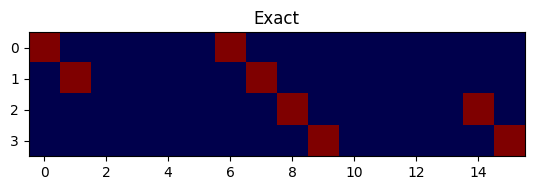

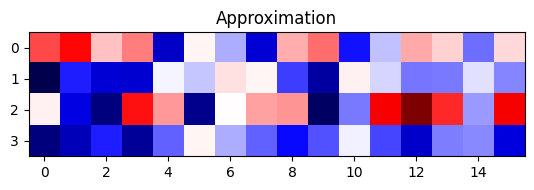

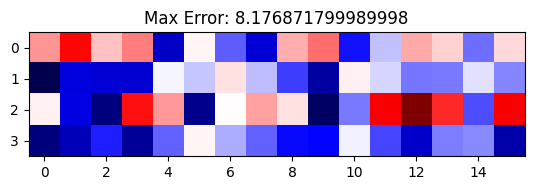

In [ ]:
display.print_triple_deltas(scheme)

In [ ]:
display.print(scheme)

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L2 norm over the field R



In [ ]:
display.print(scheme, verbose=2)

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L2 norm over the field R

Avg L1 error: 10^0.3533, Avg L2 error: 10^0.4420, max error: 10^0.9126

Products P_i = (alpha_iaa' *_aa' A_aa') *_i (beta_ibb' *_bb' B_bb')
P_1 = ( 3.924*A[1,1] +  1.283*A[1,2] +  0.096*A[2,1] + -0.193*A[2,2]) * (-0.489*B[1,1] +  1.341*B[1,2] +  0.188*B[2,1] + -0.080*B[2,2])
P_2 = (-1.390*A[1,1] + -1.892*A[1,2] + -0.316*A[2,1] + -0.580*A[2,2]) * ( 1.437*B[1,1] + -1.304*B[1,2] + -0.393*B[2,1] +  1.044*B[2,2])
P_3 = (-1.392*A[1,1] +  2.281*A[1,2] +  1.496*A[2,1] + -0.039*A[2,2]) * ( 1.068*B[1,1] +  0.790*B[1,2] +  0.909*B[2,1] +  0.545*B[2,2])
P_4 = ( 0.646*A[1,1] +  1.047*A[1,2] +  2.034*A[2,1] + -0.004*A[2,2]) * ( 0.258*B[1,1] +  1.298*B[1,2] + -0.270*B[2,1] + -0.420*B[2,2])
P_5 = (-1.858*A[1,1] +  0.382*A[1,2] + -0.964*A[2,1] +  1.041*A[2,2]) * (-0.888*B[1,1] + -1.035*B[1,2] + -0.758*B[2,1] + -0.427*B[2,2])
P_6 = (-0.563*A[1,1] +  0.365*A[1,2] +  0.276*A[2,1

red are the coefficients in alpha, blue in beta, and yellow in gamma


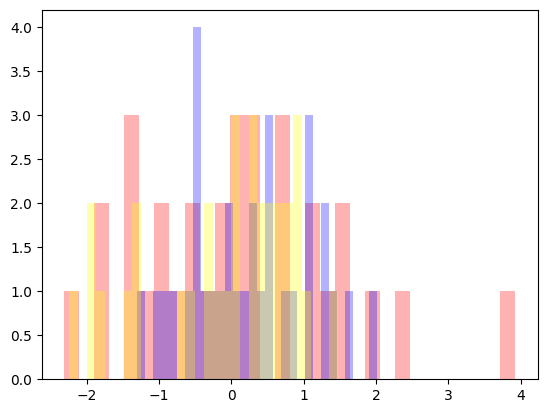

In [ ]:
display.display_spectra(scheme, verbose=1)

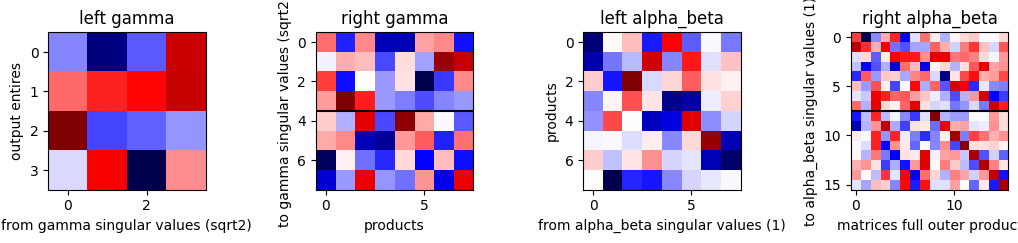

In [ ]:
display.eigen_heatmap(scheme)

After 200 stochastic tests, median avg error was 10^2.41884172.



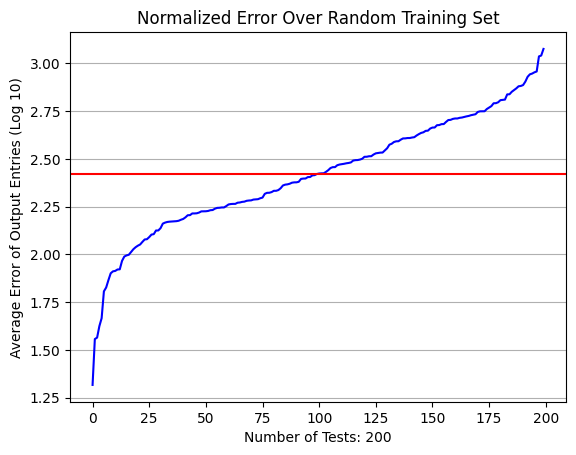

Avg L1 error: 10^0.3533, Avg L2 error: 10^0.4420, max error: 10^0.9126


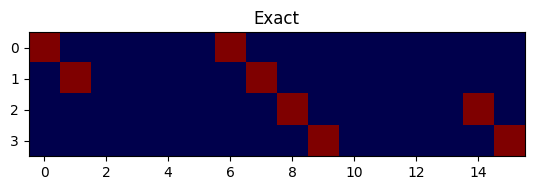

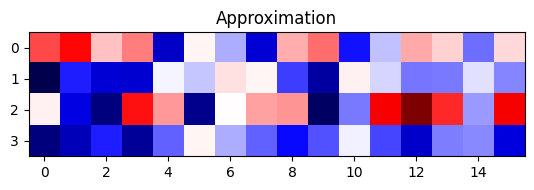

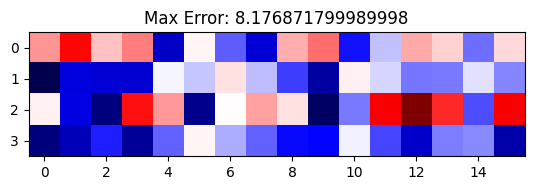

In [ ]:
display.test(scheme, verbose=4)

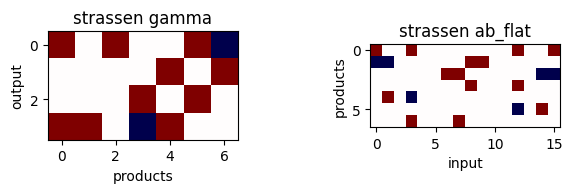

In [ ]:
factory.set_scheme(scheme, 'strassen')
display.heat_flat(scheme, name='strassen')

## Factory Tests

In [ ]:
for n in range(1,7):
  factory.set_scheme(scheme, preset='naive', n=n)
  if display.test(scheme) != -np.inf:
    print("failed on test: ", n)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
for n in range(1,5):
  for level in range(5):
    factory.set_scheme(scheme, preset='fourier', fourier_level=level, n=n)
    if display.test(scheme) > -14:
        print("failed on test: ", n,level)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
for n in range(1,9):
  factory.set_scheme(scheme, preset='random', n=n)
  print(display.test(scheme))

0.8815343815205782
0.844785479425419
0.900761128140617
0.9065645284907847
0.9123027216762849
0.8973901127818906
0.8965277018179455
0.8997489691695706


In [ ]:
for n in range(1,8):
  factory.set_scheme(scheme, preset='complex', n=n)
  print(display.test(scheme))

1.1825675899461008
1.2501527047873522
1.2825057273807874
1.2990626749264096
1.298748184088265
1.303528845442638
1.2923943400364828


In [ ]:
factory.set_scheme(scheme, preset='strassen')
if display.test(scheme) != -np.inf:
  print("failed on test: strassen")
factory.set_scheme(scheme, preset='winograd')
if display.test(scheme) > -14:
  print("failed on test: winograd")
factory.set_scheme(scheme, preset='laderman')
if display.test(scheme) > -14:
  print("failed on test: laderman")

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
for n in range(1,6):
  factory.set_from_basis(scheme, GA=random_unitary(n), GB=random_unitary(n), AB=random_unitary(n))
  if display.test(scheme) > -14:
    print("failed on test: ", n)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
for n in range(1,6):
  factory.set_from_basis(scheme, GA=random_unitary(n), GB=random_unitary(n), AB=random_unitary(n),
                           a_a=np.random.normal(scale=1, size=(n,)),
                           a_b=np.random.normal(scale=1, size=(n,)),
                           a_c=np.random.normal(scale=1, size=(n,)),
                           b_a=np.random.normal(scale=1, size=(n,)),
                           b_b=np.random.normal(scale=1, size=(n,)),
                           c_c=np.random.normal(scale=1, size=(n,)),
                           b_c=np.random.normal(scale=1, size=(n,)))
  if display.test(scheme) > -14:
      print("failed on test: ", n)

In [ ]:
for n in range(1,6):
  factory.set_from_basis(scheme, GA=random_unitary(n), GB=random_unitary(n), AB=random_unitary(n),
                           a_a=np.random.normal(scale=1, size=(n,)),
                           a_b=np.random.normal(scale=1, size=(n,)),
                           b_c=np.random.normal(scale=1, size=(n,)))
  if display.test(scheme) > -14:
      print("failed on test: ", n)

In [ ]:
for n in range(1,4):
  for m1 in range(n, n+3):
    factory.set_from_basis(scheme, GA=random_right_invertible(n=n,m=m1))
    if display.test(scheme) > -14:
      print("failed on accuracy: test", n,m1)
    if scheme.p != n*n*m1:
      print("failed on size: test", n,m1)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
for n in range(1,4):
  for m1 in range(n, n+3):
    for m2 in range(n, n+3):
      for m3 in range(n, n+3):
        factory.set_from_basis(scheme, GA=random_right_invertible(n=n,m=m1), GB=random_right_invertible(n=n,m=m2), AB=random_right_invertible(n=n,m=m3))
        if display.test(scheme) > -14:
          print("failed on test: ", n,m1,m2,m3)
        if scheme.p != m1*m2*m3:
          print("failed on size: test", n,m1,m2,m3)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
factory.set_scheme(scheme, preset='naive', n=2)
display.dump_to_file(scheme, number=10)
factory.read_from_files(scheme, n=2, p=8, number=10, verbose=2)
factory.read_from_files(scheme, filename="2_8_e10.000", verbose=2)
delete_file(n=2, p=8, number=10, scheme_or_diagram='scheme')

<ipython-input-17-ac04aa0e717e>:128: RuntimeWarning: divide by zero encountered in log10
  print(f'Avg L1 error: 10^{np.log10(L1):.4f}, Avg L2 error: 10^{np.log10(L2):.4f}, max error: 10^{np.log10(Linf):.4f}')


Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_iaa' *_aa' A_aa') *_i (beta_ibb' *_bb' B_bb')
P_1 = ( 1.000*A[1,1]) * ( 1.000*B[1,1])
P_2 = ( 1.000*A[1,2]) * ( 1.000*B[2,1])
P_3 = ( 1.000*A[1,1]) * ( 1.000*B[1,2])
P_4 = ( 1.000*A[1,2]) * ( 1.000*B[2,2])
P_5 = ( 1.000*A[2,1]) * ( 1.000*B[1,1])
P_6 = ( 1.000*A[2,2]) * ( 1.000*B[2,1])
P_7 = ( 1.000*A[2,1]) * ( 1.000*B[1,2])
P_8 = ( 1.000*A[2,2]) * ( 1.000*B[2,2])

Outputs AB_cc' = gamma_cc'i *_i P_i
AB[1,1] =  1.000*P_1 +  1.000*P_2
AB[1,2] =  1.000*P_3 +  1.000*P_4
AB[2,1] =  1.000*P_5 +  1.000*P_6
AB[2,2] =  1.000*P_7 +  1.000*P_8

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_iaa' *_aa' A_aa') *_i (bet

In [ ]:
outer = BrentScheme()
factory.set_scheme(outer, 'strassen', n=2)
inner = BrentScheme()
factory.set_scheme(inner, 'strassen', n=2)

result = factory.compose_schemes(outer, inner)
if result.n != outer.n * inner.n:
  print(f"Matrix Sizes Failed for test 1")
if result.p != outer.p * inner.p:
  print(f"Product Size Failed for test 1")
if display.test(result) > -13:
  print(f"Accuracy Failed for test 1")


outer = BrentScheme()
factory.set_scheme(outer, 'strassen', n=2)
inner = BrentScheme()
factory.set_scheme(inner, 'laderman', n=2)

result = factory.compose_schemes(outer, inner)
if result.n != outer.n * inner.n:
  print(f"Matrix Sizes Failed for test 2")
if result.p != outer.p * inner.p:
  print(f"Product Size Failed for test 2")
if display.test(result) > -13:
  print(f"Accuracy Failed for test 2")

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


## Manipulator Tests

In [ ]:
test_array = np.array([1,2,3])
print("should be 3, 6, and 3.741657...")

manipulator.set_norm(scheme, norm=1, field='R')
if scheme.L_norm != 1:
  print("didn't work: ", 1)
if scheme.field != 'R':
  print("didn't work: ", 2)
print(scheme.measure(3))
print(scheme.measure(test_array))

manipulator.set_norm(scheme, norm=1, field='C')
if scheme.L_norm != 1:
  print("didn't work: ", 3)
if scheme.field != 'C':
  print("didn't work: ", 4)
print(scheme.measure(3j))
print(scheme.measure(test_array.astype(complex)))

manipulator.set_norm(scheme, norm=2, field='R')
if scheme.L_norm != 2:
  print("didn't work: ", 5)
if scheme.field != 'R':
  print("didn't work: ", 6)
print(scheme.measure(3))
print(scheme.measure(test_array))

manipulator.set_norm(scheme, norm=2, field='C')
if scheme.L_norm != 2:
  print("didn't work: ", 7)
if scheme.field != 'C':
  print("didn't work: ", 8)
print(scheme.measure(3j))
print(scheme.measure(test_array.astype(complex)))

manipulator.set_norm(scheme, norm=np.inf, field='R')
if scheme.L_norm != np.inf:
  print("didn't work: ", 9)
if scheme.field != 'R':
  print("didn't work: ", 10)
print(scheme.measure(3))
#print(scheme.measure(test_array))

should be 3, 6, and 3.741657...
3
6
3.0
6.0
3.0
3.7416573867739413
3.0
3.7416573867739413
3.0


<ipython-input-15-30c25f03836b>:36: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  scheme.norm = lambda x : max_array(np.abs(x), axis=np.where(np.shape(x)==scheme.p)[0]) # possibly broken - requires a scheme with size p to actually measure


In [ ]:
factory.set_scheme(scheme, 'naive', n=2)
manipulator.scale_products(scheme, [1,2,3,4,5,6,7,8], [9,8,7,6,5,4,3,2])
display.print(scheme)

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R



In [ ]:
factory.set_scheme(scheme, 'naive', n=2)
manipulator.drop_product(scheme)
display.print(scheme)
manipulator.drop_product(scheme, prod=3)
display.print(scheme)

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R



In [ ]:
factory.set_scheme(scheme, 'strassen')
display.print(scheme)
manipulator.normalize(scheme)
display.print(scheme)
manipulator.set_norm(scheme, norm=2)
manipulator.normalize(scheme)
display.print(scheme)
manipulator.set_norm(scheme, norm=np.inf)
#manipulator.normalize(scheme, verbose=2)
display.print(scheme)

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L2 norm over the field R

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the Linf norm over the field R



In [ ]:
# see if the products are in groups of four according to tpye of product (test sorting products)
factory.set_scheme(scheme, 'laderman')
display.print(scheme)
# then mess them up
permute = np.arange(23)
np.random.shuffle(permute)
print(permute)
manipulator.permute_products(scheme, permutation=permute)
display.print(scheme, verbose=1)

Network trained for a 3 by 3 matrix using 23 out of 27 multiplications; complexity is n^2.854

Using the L1 norm over the field R

[17  5 19 14  1 22 13  3 16 18  0  9 20  2  4 11 10  8  7 15 12 21  6]
Network trained for a 3 by 3 matrix using 23 out of 27 multiplications; complexity is n^2.854

Using the L1 norm over the field R

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf



<ipython-input-17-ac04aa0e717e>:128: RuntimeWarning: divide by zero encountered in log10
  print(f'Avg L1 error: 10^{np.log10(L1):.4f}, Avg L2 error: 10^{np.log10(L2):.4f}, max error: 10^{np.log10(Linf):.4f}')


In [ ]:
factory.set_scheme(scheme, 'naive', n=2)
manipulator.add_noise(scheme, epsilon=10**-3)
print("-3: ", display.test(scheme))
manipulator.round(scheme, sig_figs=2)
if display.test(scheme) != -np.inf:
  print("rounding didn't work")
manipulator.add_noise(scheme, epsilon=10**-3)
manipulator.chop(scheme, num=1, verbose=2)
manipulator.round(scheme, sig_figs=2)
display.print(scheme)

-3:  -3.0830793771669818
The gamma 2-tensors associated with each product have magnitudes: [1.00208317 1.00301495 1.00074482 1.00037614 1.00136383 1.00517586
 1.00151956 1.0029211 ]
Dropping the product with magnitude: 1.0003761350816212
p is now: 7
Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field R



<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


In [ ]:
factory.set_from_basis(scheme, GA=random_unitary(2), GB=random_unitary(2), AB=random_unitary(2))

display.print(scheme)
manipulator.enforce_zero_num(scheme, num_zeros_enforced=50, decay_factor=0.0)
display.print(scheme, verbose=1)

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Network trained for a 2 by 2 matrix using 8 out of 8 multiplications; complexity is n^3.000

Using the L1 norm over the field R

Avg L1 error: 10^-1.2233, Avg L2 error: 10^-0.8882, max error: 10^-0.4923



In [ ]:
scheme = BrentScheme()
factory.set_scheme(scheme, 'laderman', n=3)
manipulator.reduce_matrices(scheme, axes=[[1], [0], [2]])
display.test(scheme)

<ipython-input-17-ac04aa0e717e>:134: RuntimeWarning: divide by zero encountered in log10
  return np.log10(scheme.avg_error(error))


-inf

In [ ]:
for n in range(2,7):
  factory.set_scheme(scheme, 'naive', n=2)
  manipulator.change_basis(scheme, GA=random_unitary(2), GB=random_unitary(2), AB=random_unitary(2))
  if display.test(scheme) > -14:
    print("rounding didn't work: n={}".format(n))

### TODO FIXME: test fat/tall GA,GB,AB
### See factory tests

## Scheme Method Tests

In [ ]:
# the others are pretty well tested in the display object
factory.set_scheme(scheme, 'naive', n=3)
for i in range (10):
  A = random_unitary(3)
  B = random_unitary(3)
  if np.log10(scheme.measure(scheme.predict(A, B) - (A @ B))) > -14:
    print("failure")

## Single-Epoch Training Tests

In [ ]:
factory.set_scheme(scheme, 'random', n=3, p=22)
epochs = 50

for i in range(epochs):
  stepper.epoch_pseudoinverse(scheme)
if display.test(scheme) > -1.4:
  print("Run pseudoinverse test again, may be faulty")

In [ ]:
factory.set_scheme(scheme, 'random', n=2, p=8)
LR = 2
epochs = 500

for i in range(epochs):
  stepper.epoch_deterministic(scheme, learning_rate=10**-LR)
if display.test(scheme) > -1.5:
  print("Run deterministic test again, may be faulty")

In [ ]:
factory.set_scheme(scheme, 'random', n=2, p=8)
LR = 1
epochs = 200

for i in range(epochs):
  stepper.epoch_torch(scheme, learning_rate=10**-LR, momentum=0.9)
if display.test(scheme) > -1.5:
  print("Run torch test again, may be faulty")

In [ ]:
factory.set_scheme(scheme, 'random', n=2, p=8)
LR = 2
epochs = 5000

for i in range(epochs):
  stepper.epoch_stocastic(scheme, learning_rate=10**-LR)
if display.test(scheme) > -1.5:
  print("Run stochastic test again, may be faulty")

## Multi-Epoch Training Tests

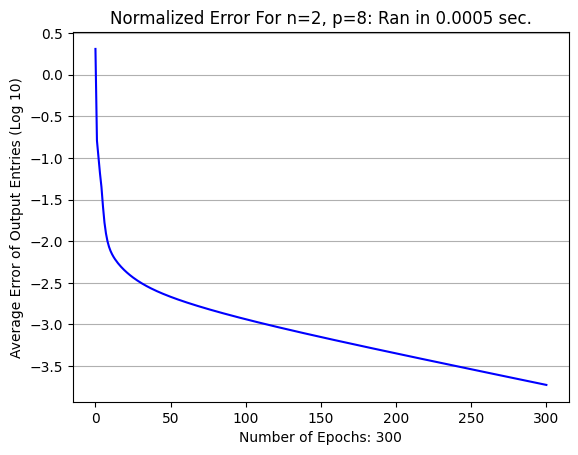

In [ ]:
factory.set_scheme(scheme, 'random', n=2, p=8)
trainer.train(scheme, epochs=300, batch_size=1, decay_rate=0.01, verbose=1)

RESET AFTER 5 NO-CHANGE ITERATIONS: ACCURACY WAS 10^-3.42


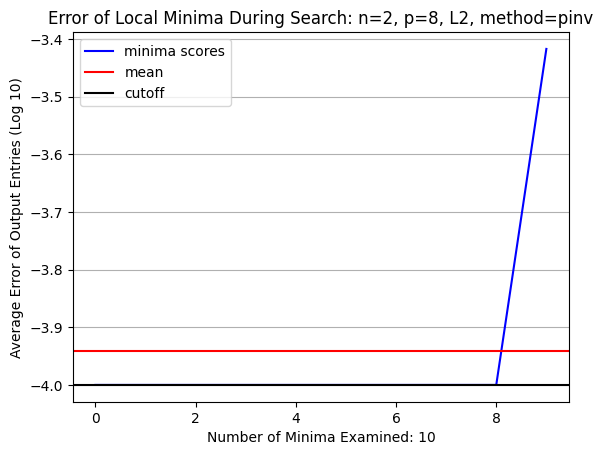

In [ ]:
trainer.search(n=2, p=8, num_trials=10,
               epochs=20, early_stop=False, sig_fig_stop=4, save_cutoff=7,
               improvement_tol=0.01, verbose=2)

## Independent Function Tests

In [ ]:
for n in range(1,7):
  A = random_unitary(2)
  if np.sum(np.abs(A @ A.T - np.identity(2))) > 10**-14:
    print("failed for n=", n)

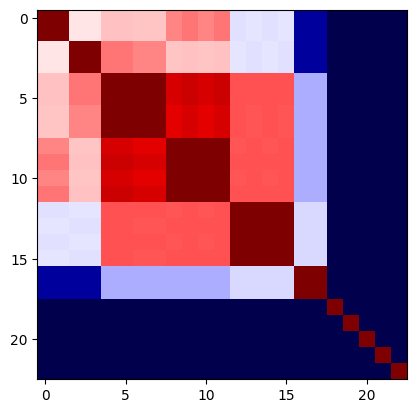

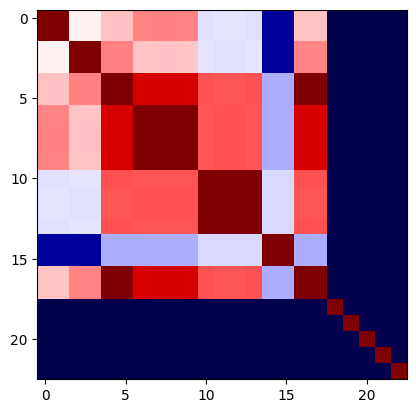

In [ ]:
## sort / partition the eigenvectors of the scheme

factory.set_scheme(scheme, 'laderman') # 'random' 'complex' 'naive' 'fourier' 'strassen' 'winograd' 'laderman'

gamma, products = scheme.flatten()
u,s,v_t = np.linalg.svd(gamma)
u2,s2,v_t2 = np.linalg.svd(products)
heat_plot(np.abs(u2) @ np.abs(u2).T, "", "", "")

manipulator.permute_products(scheme, verbose=0)

gamma, products = scheme.flatten()
u,s,v_t = np.linalg.svd(gamma)
u2,s2,v_t2 = np.linalg.svd(products)
heat_plot(np.abs(u2) @ np.abs(u2).T, "", "", "")

In [ ]:
for n in range(1,4):
  for m in range(n, n+3):
    A = random_right_invertible(n=n,m=m)
    A_inv = np.linalg.pinv(A)
    if np.sum(np.abs(A @ A_inv - np.identity(n))) > 10**-14:
      print("failed for n=", n)

In [ ]:
if left_axis_size(GA=np.identity(5), GB=np.identity(5), AB=np.identity(5)) != 5:
  print("failed test 1")
if left_axis_size(GA=np.arange(9).reshape((3,3)), GB=np.arange(9).reshape((3,3)), AB=np.arange(9).reshape((3,3))) != 3:
  print("failed test 2")
if left_axis_size(GA=np.arange(12).reshape((2,6)), GB=np.arange(10).reshape((2,5)), AB=np.arange(8).reshape((2,4))) != 2:
  print("failed test 3")
print("Should display error for wrong sizes:")
left_axis_size(GA=np.arange(12).reshape((2,6)), GB=np.arange(10).reshape((2,5)), AB=np.arange(8).reshape((4,2)))

Should display error for wrong sizes:
The basis matrices must have the same left dimensions


# Workspace

Network trained for a 2 by 2 matrix using 7 out of 8 multiplications; complexity is n^2.807

Using the L1 norm over the field C

Avg L1 error: 10^-inf, Avg L2 error: 10^-inf, max error: 10^-inf

Products P_i = (alpha_iaa' *_aa' A_aa') *_i (beta_ibb' *_bb' B_bb')
P_1 = ( 1.000+0.000j*A[1,1] +  0.000+1.000j*A[2,2]) * ( 1.000+0.000j*B[1,1] +  0.000-1.000j*B[2,2])
P_2 = (-1.000+0.000j*A[1,1] +  1.000+0.000j*A[2,1]) * ( 1.000+0.000j*B[1,1] +  1.000+0.000j*B[1,2])
P_3 = ( 0.000+1.000j*A[1,2] +  0.000-1.000j*A[2,2]) * ( 0.000-1.000j*B[2,1] +  0.000-1.000j*B[2,2])
P_4 = ( 1.000+0.000j*A[2,1] +  0.000+1.000j*A[2,2]) * ( 1.000+0.000j*B[1,1])
P_5 = ( 1.000+0.000j*A[1,1]) * ( 1.000+0.000j*B[1,2] +  0.000+1.000j*B[2,2])
P_6 = ( 0.000+1.000j*A[2,2]) * (-1.000+0.000j*B[1,1] +  0.000-1.000j*B[2,1])
P_7 = ( 1.000+0.000j*A[1,1] +  0.000+1.000j*A[1,2]) * ( 0.000-1.000j*B[2,2])

Outputs AB_cc' = gamma_cc'i *_i P_i
AB[1,1] =  1.000+0.000j*P_1 +  1.000+0.000j*P_3 +  1.000+0.000j*P_6 + -1.000+0.000j*P_7
AB[1

<ipython-input-17-ac04aa0e717e>:128: RuntimeWarning: divide by zero encountered in log10
  print(f'Avg L1 error: 10^{np.log10(L1):.4f}, Avg L2 error: 10^{np.log10(L2):.4f}, max error: 10^{np.log10(Linf):.4f}')


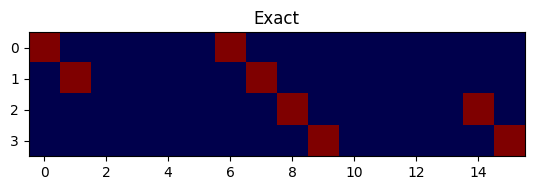

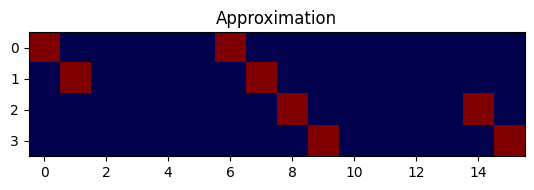

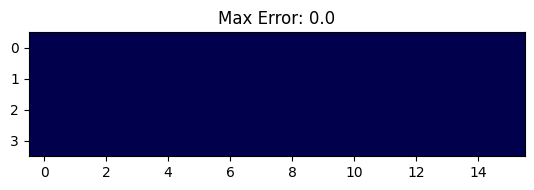

In [ ]:
#manipulator.set_norm(scheme, norm=2, field='C')
#factory.set_Perry(scheme)
#trainer.train(scheme, epochs=300, batch_size=1, decay_rate=0.01, verbose=1)

factory.set_scheme(scheme, 'strassen')
GA = np.array([[1,0],[0,1]])
GB = np.array([[1,0],[0,1]])
AB = np.array([[1,0],[0,1j]])
manipulator.change_basis(scheme, GA=GA, GB=GB, AB=AB)


display.print(scheme, verbose=2)
display.print_triple_deltas(scheme)


In [ ]:
# @title File Save/Read Functions
# display.dump_to_file(scheme)
# download_file(n=3, p=22, number=-2.771, scheme_or_diagram='scheme')
# delete_file(n=3, p=22, number=-2.114, scheme_or_diagram='scheme')

In [ ]:
# @title Enforce Zeros During Training
# do something like Grahm Schmidt to alpha*beta, using the rotations discovered for the other methods to seperate the similar/different components of products (they are often subtracted if they are similar, and scale out of control)
factory.set_scheme(scheme, 'random', n=2, p=8)
manipulator.set_norm(scheme, norm=1)

num_zeros_enforced=50
rounds=100

# stepper.epoch_pseudoinverse(scheme)
# stepper.epoch_pseudoinverse(scheme)
# stepper.epoch_pseudoinverse(scheme)
# stepper.epoch_pseudoinverse(scheme)
# stepper.epoch_pseudoinverse(scheme)

for i in range(rounds):
  manipulator.normalize(scheme)
  if not test_degeneracy(scheme, cond=100):
    manipulator.enforce_zero_num(scheme, num_zeros_enforced=np.ceil(num_zeros_enforced * (i+1)/rounds), sig_figs=15)
  else:
    i -= 1
  stepper.epoch_pseudoinverse(scheme)
  stepper.epoch_pseudoinverse(scheme)
  stepper.epoch_pseudoinverse(scheme)
manipulator.normalize(scheme)
manipulator.enforce_zero_num(scheme, num_zeros_enforced=num_zeros_enforced, sig_figs=15, decay_factor=0.0)
manipulator.normalize(scheme)


display.print(scheme, verbose=1)
test_degeneracy(scheme)


NameError: name 'test_degeneracy' is not defined

In [ ]:
def add_products(scheme, recv_prod, from_prod, scale=1):
  recv_prod -= 1
  from_prod -= 1
  if np.all(scheme.beta_pnn[recv_prod,:,:] == scheme.beta_pnn[from_prod,:,:]):
    scheme.alpha_pnn[recv_prod,:,:] += scale * scheme.alpha_pnn[from_prod,:,:]
    scheme.gamma_nnp[:,:,from_prod] -= scale * scheme.gamma_nnp[:,:,recv_prod]
  elif np.all(scheme.alpha_pnn[recv_prod,:,:] == scheme.alpha_pnn[from_prod,:,:]):
    scheme.beta_pnn[recv_prod,:,:] += scale * scheme.beta_pnn[from_prod,:,:]
    scheme.gamma_nnp[:,:,from_prod] -= scale * scheme.gamma_nnp[:,:,recv_prod]
  elif np.allclose(np.einsum('aA,bB->aAbB', scheme.alpha_pnn[recv_prod,:,:], scheme.beta_pnn[recv_prod,:,:]),
                   np.einsum('aA,bB->aAbB', scheme.alpha_pnn[from_prod,:,:], scheme.beta_pnn[from_prod,:,:]),
                   rtol = 10**-2) or np.allclose(np.einsum('aA,bB->aAbB', scheme.alpha_pnn[recv_prod,:,:], scheme.beta_pnn[recv_prod,:,:]),
                   -np.einsum('aA,bB->aAbB', scheme.alpha_pnn[from_prod,:,:], scheme.beta_pnn[from_prod,:,:]),
                   rtol = 10**-2):
    scheme.alpha_pnn[recv_prod,:,:] = (scheme.alpha_pnn[recv_prod,:,:] + scheme.alpha_pnn[from_prod,:,:])/2.0
    scheme.beta_pnn[recv_prod,:,:] = (scheme.beta_pnn[recv_prod,:,:] + scheme.beta_pnn[from_prod,:,:])/2.0
    scheme.gamma_nnp[:,:,recv_prod] = (scheme.gamma_nnp[:,:,recv_prod] + scheme.gamma_nnp[:,:,from_prod])/2.0
    SchemeManipulator().drop_product(scheme, prod=from_prod)
  else:
    print("The products had no similar factor. Should I find a way to shuffle them?")


In [ ]:
add_products(scheme, 3,6,0)
display.print(scheme, verbose=1)


In [ ]:
# @title Change of Basis Existing to Existing

# gamma1 * alpha1 * beta1 * GAB = gamma2 * alpha2 * beta2


# G = alpha2 * beta2  * pinv(alpha1 * beta1)
# A = gamma2 * beta2  * pinv(gamma1 * beta1)
# B = gamma2 * alpha2 * pinv(gamma1 * alpha1)

scheme1 = BrentScheme()
scheme2 = BrentScheme()
factory.set_scheme(scheme1, 'naive', n=2)
GA=np.identity(2)
GA[0,1] = 2
factory.set_from_basis(scheme2, GA=GA, GB=np.identity(2), AB=np.identity(2))

# ab1 = np.einsum('iaA,ibB->iaAbB', scheme1.alpha_pnn, scheme1.beta_pnn).reshape((scheme1.p, scheme1.n**4))
# ab2 = np.einsum('iaA,ibB->iaAbB', scheme2.alpha_pnn, scheme2.beta_pnn).reshape((scheme2.p, scheme2.n**4))
# G = np.einsum('ik,kj->ij', ab1, np.linalg.pinv(ab2))

# gb1 = np.einsum('cCi,ibB->icCbB', scheme1.gamma_nnp, scheme1.beta_pnn).reshape((scheme1.p, scheme1.n**4))
# gb2 = np.einsum('cCi,ibB->icCbB', scheme2.gamma_nnp, scheme2.beta_pnn).reshape((scheme2.p, scheme2.n**4))
# A = np.einsum('ik,kj->ij', gb1, np.linalg.pinv(gb2))

ga1 = np.einsum('cCi,iaA->icCaA', scheme1.gamma_nnp, scheme1.alpha_pnn).reshape((scheme1.p, scheme1.n**4))
ga2 = np.einsum('cCi,iaA->icCaA', scheme2.gamma_nnp, scheme2.alpha_pnn).reshape((scheme2.p, scheme2.n**4))
B = np.einsum('ik,kj->ij', ga1, np.linalg.pinv(ga2))

display.print(scheme2)
# np.einsum('cCi,ij->cCj', scheme2.gamma_nnp, G) == scheme1.gamma_nnp
# np.einsum('iaA,ij->jaA', scheme2.alpha_pnn, A) == scheme1.alpha_pnn
# np.einsum('ibB,ij->jbB', scheme2.beta_pnn,  B) == scheme1.beta_pnn



In [ ]:
# @title Change of Basis Existing to New
# Use a generated scheme with one off-diagonal altered to get a feel for elementary transformations.
# take the tensor inverse of the existing and generated schemes to find change of basis for them to eachother. look for patterns.
factory.set_scheme(scheme, 'naive', n=3)
n=3
p=27
Q = random_unitary(p)


G = None
A = None
B = None


if G is None:
  G = np.identity(p)
if A is None:
  A = np.identity(p)
if B is None:
  B = np.identity(p)

add_products(scheme, recv_prod=1, from_prod=1, scale=0)

if not np.allclose(np.einsum('ij,ij,ij->ij', G, A, B), np.identity(p)): # could be a permutation, not just identity
  print("product was not ones: ", np.einsum('ij,ij,ij->ij', G, A, B))

scheme.gamma_nnp = np.einsum('cCi,ij->cCj', scheme.gamma_nnp, G)
scheme.alpha_pnn = np.einsum('iaA,ij->jaA', scheme.alpha_pnn, A)
scheme.beta_pnn  = np.einsum('ibB,ij->jbB', scheme.beta_pnn,  B)


display.print(scheme, verbose=1)
display.print_triple_deltas(scheme)

In [ ]:
# should I automatically cut the bad product when this is degenerate?
def test_degeneracy(scheme, cond=100):
  if np.linalg.cond(np.einsum('iaA,ibB->iaAbB', scheme.alpha_pnn, scheme.beta_pnn).reshape((scheme.p, scheme.n**4))) > cond:
    return True
  return False


In [ ]:
factory.set_scheme(scheme, 'strassen', n=2, p=8)
add_products(scheme,  recv_prod=1, from_prod=2, scale=2)
display.print(scheme, verbose=1)

In [ ]:
# @title Delta Rotation
# if we use a simple scheme (just adding vlid products to eachother) gamma projets first and becomes exact after one projection- try scheme.alpha_pnn[0,1,0] = 2
factory.set_scheme(scheme, 'naive', n=2, p=8)
scheme.alpha_pnn[0,1,0] = 2
display.print(scheme)

for i in range(1):
  stepper.epoch_pseudoinverse(scheme)

display.print(scheme, verbose=1)

naive = BrentScheme()
factory.set_scheme(naive, 'naive', n=2, p=8)

scheme.gamma_nnp -= naive.gamma_nnp
scheme.alpha_pnn -= naive.alpha_pnn
scheme.beta_pnn  -= naive.beta_pnn

scale = 10**4
scheme.gamma_nnp *= scale
scheme.alpha_pnn *= scale
scheme.beta_pnn  *= scale

scheme.gamma_nnp = np.round(scheme.gamma_nnp)
scheme.alpha_pnn = np.round(scheme.alpha_pnn)
scheme.beta_pnn  = np.round(scheme.beta_pnn)

display.print(scheme)
heat_all(naive, name='naive')
heat_all(scheme, name='deltas')

In [ ]:
strassen = BrentScheme()
factory.set_scheme(strassen, 'strassen', n=2)
scheme = factory.compose_schemes(strassen, strassen)
scheme = factory.compose_schemes(scheme, strassen)
display.print(scheme, verbose=2)

In [ ]:
BSSF = [0,0,0]
BSSF_complexity = 5.0
strassen = BrentScheme()
laderman = BrentScheme()
factory.set_scheme(strassen, 'strassen', n=2)
factory.set_scheme(laderman, 'laderman', n=2)
scheme = factory.compose_schemes(strassen, laderman)
display.print(scheme, verbose=0)
temp = BrentScheme()

for i in range(scheme.n-1, -1, -1):
  for j in range(scheme.n-1, -1, -1):
    print(f"j={j}")
    for k in range(scheme.n-1, -1, -1):
      print(f"k={k}")
      factory.set_from(temp, alpha_pnn=scheme.alpha_pnn, beta_pnn=scheme.beta_pnn, gamma_nnp=scheme.gamma_nnp)
      manipulator.reduce_matrices(temp, axes=[i,j,k])
      manipulator.clean(temp)
      if temp.complexity() < BSSF_complexity:
        BSSF_complexity = temp.complexity()
        BSSF = [i,j,k]
        print(temp.complexity())
# Try to derive Laderman's from Strassen's this way. (2-4-3)
# combine the reduce_matrices and clean functions to optimize better (clean as we go)

In [ ]:
# change train and search methods to take the function to be used and a argument dict to be unpacked (not just pseudoinverse)
# add a momentum term to pseudoinverse using previous step?
# train function can optionally enforce a specified number of zeros by a specified decay rate
# try negative decay rates for better convergence (-0.7)

In [ ]:
# SVD the triple delta. Try to get the right row vectors to be outer products.
# Get a feel for what outer product vectors look like.
# Try the Vandermonde fourir baisis from my notebook to encode outer product factors.


def heat_all(scheme, name=""):
  plt.subplot(1, 3, 1)
  heat_plot(scheme.gamma_nnp.reshape((scheme.n**2, scheme.p)), title=name+" gamma", xlabel='products', ylabel="output")
  plt.subplot(1, 3, 2)
  heat_plot(scheme.alpha_pnn.reshape((scheme.p, scheme.n**2)), title=name+" alpha", xlabel='left_input', ylabel="products")
  plt.subplot(1, 3, 3)
  heat_plot(scheme.beta_pnn.reshape((scheme.p, scheme.n**2)), title=name+" beta", xlabel='right_input', ylabel="products")
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.7)
  plt.show()

factory.set_from_basis(scheme, GA=random_unitary(2), GB=random_unitary(2), AB=random_unitary(2))
display.heat_flat(scheme, name='random')

factory.set_scheme(scheme, 'naive', n=2, p=8)
display.heat_flat(scheme, name='naive')

factory.set_scheme(scheme, 'fourier', n=2, p=8, fourier_level=1)
display.heat_flat(scheme, name='forier1')

factory.set_scheme(scheme, 'fourier', n=2, p=8, fourier_level=2)
display.heat_flat(scheme, name='forier2')

factory.set_scheme(scheme, 'strassen', n=2, p=7)
display.heat_flat(scheme, name='strassen')

factory.set_scheme(scheme, 'winograd', n=2, p=7)
display.heat_flat(scheme, name='winograd')

u,s,v_t = np.linalg.svd(scheme.TRIPLE_DELTA_n2n4)
plt.subplot(1, 2, 1)
heat_plot(u, title="gamma")
plt.subplot(1, 2, 2)
heat_plot(v_t[:,:], title="ab_flat")
plt.axhline(y=u.shape[1]-0.5, color='black')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=0.7)
plt.show()

## The following is a driver that calculates baseline accuracies for a randomly generated scheme with the following parameters:
  - $n$: the size of the matrix
  - $t$: the trials used for the average
  - $p$: the number of products
  - $e$: the number of epochs
  - $a$: the accuracy (LR and DR in $10^{-a}$)

If any of these parameters are not given, the default behavior is the following:
  - $n$: test both 2x2 and 3x3 schemes
  - $t$: use 5 trials for each parameter combination
  - $p$: test all values from $n^3$ down to 0
  - $e$: test 0, 1K, and 10K and output all three results
  - $a$: the with LR and DR $10^{-5}$)

All of these parameters must be given as a list (except $e$), even if they are singleton, and the output will be printed in this order:
  - the blocks will be for matrices of the same size $n$, as indicated by their headers
  - each row will correspond with a number of products $p$ as labeled
  - each entry in the row will correspond with the average accuracy after $e$ epochs over $t$ trials, as indicated by the key at the start of the output

REDO: FIND ERRORS FOR LOCAL MINIMA FOR GIVEN N,P, CLASSIFY THEM (Get A RANGE FOR THE ERROR OF EACH FAMILY) AND ESTIMATE THEIR DENSITY IN THE SPACE.

In [ ]:
# a method for testing how many iterations on average it takes to reach a certain threshold
# a method for automatically detecting local minima values, storing them, and optionally finding minima with a specific value.

In [ ]:
#factory.set_scheme(scheme, 'complex', n=3, p=23)
trainer.train(scheme, epochs=10, verbose=1)
trainer.train(scheme, epochs=600, verbose=1)

In [ ]:
n = 2
t = 5
p = 7
e = [0, 1_000, 10_000]
a = [5]


data = np.zeros((n,p,t))

for ni in n:
  for pi in p:
    for ti in t:
      trainer = Trainer(n=ni, p=pi)
      trainer.train(epochs=epochs, learning_rate=10**-sig_figs, decay_rate=10**-(sig_figs*1.1), verbose=1)
      for ei in range(len(e)):
        break

data = data.astype('|S3')
print("Ran tests and obtained the following average errors:")
print(f"The key explaining the numbers of epochs")
for ni in n:
  print(f"\nErrors on schemes for {ni}x{ni} matrices:")
  for pi in p:
    print(f"{pi} mult: GO THOUGH LIST OVER ti")